In [1]:
import importlib
import torch
import torch.nn as nn
from torch.optim import AdamW, Optimizer, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scratchers.vanilla_transformer.attn import Attention
from scratchers.transformer_config import TransformerConfig

from scratchers.encoder_decoder_transformer import Transformer

# Data generation

In [2]:
SOURCE_SEQ_LEN = 12
TARGET_SEQ_LEN = 12

DATA_SIZE = 2000
TRAIN_SIZE = int(DATA_SIZE * 0.8)
TEST_SIZE = DATA_SIZE - TRAIN_SIZE

# radii = np.random.ranf((DATA_SIZE)) # * 9 + 1
radii = np.ones((DATA_SIZE))
starting_radian = np.random.ranf((DATA_SIZE)) * 2 * np.pi
directions = np.random.randint(2, size=DATA_SIZE) * 2 - 1

def to_cartesian(
    radius: float,
    start_radian: float, 
    direction: int
):
    delta = 2 * np.pi / (SOURCE_SEQ_LEN + TARGET_SEQ_LEN)
    seq = np.array([
        np.array([
            radius * np.cos(start_radian + (i * direction * delta)),
            radius * np.sin(start_radian + (i * direction * delta))
        ])
        for i in range(SOURCE_SEQ_LEN + TARGET_SEQ_LEN)
    ])
    source_seq = seq[:SOURCE_SEQ_LEN]
    target_seq = seq[SOURCE_SEQ_LEN:]
    return source_seq, target_seq

def make_circles_data():
    X = np.empty((DATA_SIZE, (SOURCE_SEQ_LEN), 2))
    Y = np.empty((DATA_SIZE, (SOURCE_SEQ_LEN), 2))
    for idx, (radius, start_radian, direction) in enumerate(zip(radii, starting_radian, directions)):
        x, y = to_cartesian(radius, start_radian, direction)
        X[idx, :, :] = x
        Y[idx, :, :] = y

    return (
        torch.from_numpy(X[:TRAIN_SIZE]).float(), 
        torch.from_numpy(Y[:TRAIN_SIZE]).float(),
        torch.from_numpy(X[TRAIN_SIZE:]).float(), 
        torch.from_numpy(Y[TRAIN_SIZE:]).float()
    )

X_train, y_train, X_test, y_test = make_circles_data()

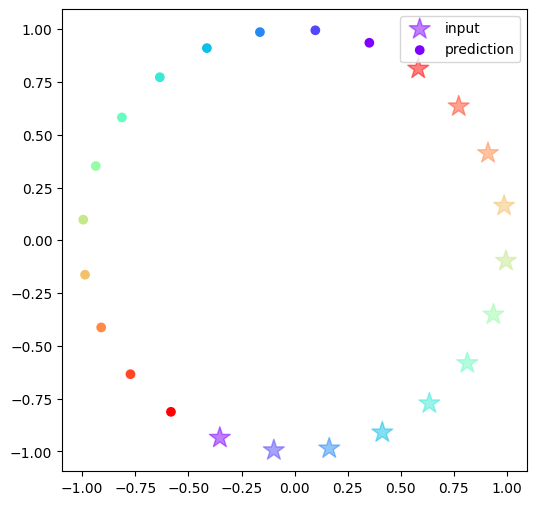

In [3]:
def plot_circle(input, prediction, figsize=(6, 6)):
    plt.figure(figsize=figsize)
    colors = cm.rainbow(np.linspace(0, 1, len(input)))
    plt.scatter(
        input[:, 0], input[:, 1], label="input", marker="*", s=250, alpha=0.5, color=colors
    )
    plt.scatter(prediction[:, 0], prediction[:, 1], label="prediction", color=colors)
    plt.legend()

plot_circle(X_train[4], y_train[4])

# Train

In [4]:
cfg = TransformerConfig(
    input_size=2,
    attn_d_k=64,
    transformer_proj_dim=128,
    dropout=0.2,
    nlayers=3,
    is_self_attn=False,
    max_seq_len=TARGET_SEQ_LEN + SOURCE_SEQ_LEN,
    nheads=2,
    pre_layer_norm=True,
    use_cache=True
)

In [5]:
class Trainer:
    def __init__(
        self,
        train_data_loader: DataLoader,
        test_data_loader: DataLoader,
        optimizer: Optimizer,
        model: nn.Module,
        lr_scheduler = None,
        epochs: int = 10,
    ):
        self.train_data_loader = train_data_loader
        self.test_data_loader = test_data_loader
        self.optimizer = optimizer
        self.model = model
        self.lr_scheduler = lr_scheduler
        self.epochs = epochs

    @property
    def device(self):
      return 'cuda' if torch.cuda.is_available() else 'cpu'

    def train(self, loss_fn: callable):
        self.model.to(self.device)
        for epoch in range(self.epochs):
            losses = []
            self.model.train()
            for x_batch, y_batch in self.train_data_loader:
                out = self.model(x_batch, torch.cat((x_batch[:, -1:, :], y_batch[:, :-1, :]), dim=-2))
                loss = loss_fn(out, y_batch)
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                losses.append(loss.detach().cpu().numpy())

            if self.lr_scheduler is not None:
                self.lr_scheduler.step()

            print(f"Train loss at epoch ({epoch}): ", np.array(losses).mean())

            with torch.no_grad():
                self.model.eval()
                test_losses = []
                for x_batch, y_batch in self.test_data_loader:
                    out = self.model(x_batch, torch.cat((x_batch[:, -1:, :], y_batch[:, :-1, :]), dim=-2))
                    loss = loss_fn(out, y_batch)
                    test_losses.append(loss.detach().cpu().numpy())

                print(f"Test loss at epoch ({epoch}): ", np.array(test_losses).mean())

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
train_dataset = TensorDataset(X_train.to(device), y_train.to(device))
test_dataset = TensorDataset(X_test.to(device), y_test.to(device))

EPOCHS = 1500

train_data_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)
transformer = Transformer(cfg)
optimizer = SGD(transformer.parameters(), lr=1e-4, momentum=0.9)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)
trainer = Trainer(
    train_data_loader=train_data_loader,
    test_data_loader=test_data_loader,
    # optimizer=AdamW(decoder.parameters(), lr=1e-5),
    optimizer=optimizer,
    model=transformer,
    lr_scheduler=lr_scheduler,
    epochs=EPOCHS
)

trainer.train(loss_fn=nn.L1Loss())

Train loss at epoch (0):  1.2317655
Test loss at epoch (0):  0.9702111
Train loss at epoch (1):  0.79569405
Test loss at epoch (1):  0.64623326
Train loss at epoch (2):  0.6412567
Test loss at epoch (2):  0.6002227
Train loss at epoch (3):  0.59938544
Test loss at epoch (3):  0.5557897
Train loss at epoch (4):  0.551968
Test loss at epoch (4):  0.49557793
Train loss at epoch (5):  0.51059216
Test loss at epoch (5):  0.45352432
Train loss at epoch (6):  0.48009655
Test loss at epoch (6):  0.42491102
Train loss at epoch (7):  0.4486423
Test loss at epoch (7):  0.399666
Train loss at epoch (8):  0.42541182
Test loss at epoch (8):  0.36939925
Train loss at epoch (9):  0.40783888
Test loss at epoch (9):  0.35187095
Train loss at epoch (10):  0.3924217
Test loss at epoch (10):  0.3436376
Train loss at epoch (11):  0.38283885
Test loss at epoch (11):  0.32793137
Train loss at epoch (12):  0.37004268
Test loss at epoch (12):  0.3119199
Train loss at epoch (13):  0.35977152
Test loss at epoch (

In [8]:
def infer_transformer_enc_dec(x, model, output_len):
  tgt_seq = x[:, -1:, :]
  for i in range(output_len):
    out = model(x, tgt_seq)
    tgt_seq = torch.cat((tgt_seq, out[:, -1:, :]), dim=-2)

  return tgt_seq[:, 1:, :]

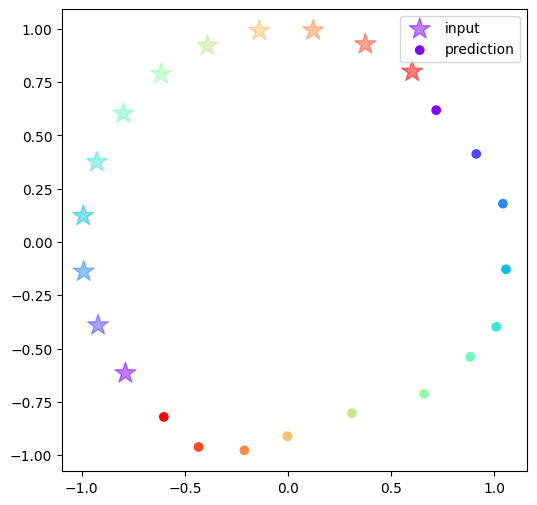

In [21]:
x_sample, y_sample = test_dataset[np.random.randint(0, TEST_SIZE)]
predictions = infer_transformer_enc_dec(x_sample.unsqueeze(0), transformer, output_len=TARGET_SEQ_LEN)
labels = torch.cat((x_sample, y_sample[-1:]))

plot_circle(
    input=x_sample.detach().cpu().numpy(),
    prediction=predictions[0].detach().cpu().numpy(),
)